In [53]:
import numpy as np
import cv2
import csv
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, losses
from tensorflow.keras.applications.vgg16 import VGG16


## **Data Loading**

In [3]:
!wget "https://sussex.box.com/shared/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo" -O training_images.npz
!wget "https://sussex.box.com/shared/static/i0apaktucm7y4od7k4ux69k8t1iue7w8" -O test_images.npz
!wget "https://sussex.box.com/shared/static/aulkv3tf2fc0765yqgfm9am87vgn3p8a" -O examples.npz

def confirm_checksum(filename, true_checksum):
    import subprocess
    checksum = subprocess.check_output(['shasum',filename]).decode('utf-8')
    assert checksum.split(' ')[0] == true_checksum, 'Checksum does not match for ' + filename + ' redownload the data.'

confirm_checksum('training_images.npz', 'cf2a926d2165322adcd19d2e88b2eb1cd200ea5c')
confirm_checksum('examples.npz', '0fadc9226e4c0efb4479c5c1bf79491d75828ad3')
confirm_checksum('test_images.npz', 'c7b4b297c7e5c5009706f893ad1fb77a2aa73f95')

data = np.load('training_images.npz', allow_pickle=True)
train_images = data['images']
train_points = data['points']

test_data = np.load('test_images.npz', allow_pickle=True)
test_images = test_data['images']

example_data = np.load('examples.npz', allow_pickle=True)
example_images = example_data['images']

--2024-05-04 17:58:55--  https://sussex.box.com/shared/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo
Resolving sussex.box.com (sussex.box.com)... 74.112.186.144
Connecting to sussex.box.com (sussex.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo [following]
--2024-05-04 17:58:55--  https://sussex.box.com/public/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo
Reusing existing connection to sussex.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sussex.app.box.com/public/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo [following]
--2024-05-04 17:58:55--  https://sussex.app.box.com/public/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo
Resolving sussex.app.box.com (sussex.app.box.com)... 74.112.186.144
Connecting to sussex.app.box.com (sussex.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://euc1.b

## **Data Preprocessing**

In [4]:
def preprocess_images(images):
    return images / 255.0  # Normalize images

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)


In [5]:
print(len(train_images))
print(len(test_images))

2811
554


## **Model Architecture** 

In [11]:
num_landmarks = train_points.shape[1]

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Add custom layers to the base model
x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
predictions = layers.Dense(num_landmarks * 2, activation='linear')(x)

# Define the new model
model = models.Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

## **Training** 

In [13]:
def custom_mse_loss(y_true, y_pred):
    # Reshape y_pred to match the shape of y_true
    y_pred_reshaped = tf.reshape(y_pred, (-1, num_landmarks, 2))
    # Compute mean squared error
    mse = tf.reduce_mean(tf.square(y_true - y_pred_reshaped), axis=-1)
    # Return the mean of the mean squared error across all landmarks
    return tf.reduce_mean(mse)


def train_model(model, train_images, train_points, epochs=20, batch_size=32):
    train_points = np.reshape(train_points, (-1, 44, 2))
    model.compile(optimizer='adam', loss=custom_mse_loss)
    y_pred = model.predict(train_images)
    print('y_pred shape:', y_pred.shape)
    print('train_points shape:', train_points.shape)
    history = model.fit(train_images, train_points, epochs=epochs, batch_size=batch_size)
    return history

history = train_model(model, train_images, train_points)

 3/88 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step 

W0000 00:00:1714846123.903425     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step
y_pred shape: (2811, 88)
train_points shape: (2811, 44, 2)
Epoch 1/20
 2/88 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - loss: 19232.7734

W0000 00:00:1714846138.960305     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - loss: 3920.2185
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - loss: 141.5265
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - loss: 70.7307
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - loss: 39.0989
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - loss: 39.9006
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - loss: 26.2016
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - loss: 22.0059
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - loss: 19.1754
Epoch 9/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - loss: 17.2367
Epoch 10/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - loss: 15.2322
Epoch 11/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - loss: 15.8456
Epoch 12/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - loss: 16.5504
Epoch 13/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - loss: 16.1952
Epoch 14/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - loss: 17.0275
Epoch 15/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - loss: 12.7

## **Evaluation** 

In [15]:
def load_data(filename):
    with np.load(filename) as f:
        images = f['images']
    return images

def evaluate_model(model, test_images, output_file='predictions.npz'):
    predictions = model.predict(test_images)

    # Reshape the predictions to match the expected shape of the landmark points
    num_images = len(test_images)
    num_landmarks = predictions.shape[1] // 2
    predictions = predictions.reshape((num_images, num_landmarks, 2))

    # Save the predictions to a file
    np.savez_compressed(output_file, predictions=predictions)

    return predictions

test_images = load_data('test_images.npz')
test_images = preprocess_images(test_images)
predictions = evaluate_model(model, test_images, output_file='test_predictions.npz')

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


## **Visualization**


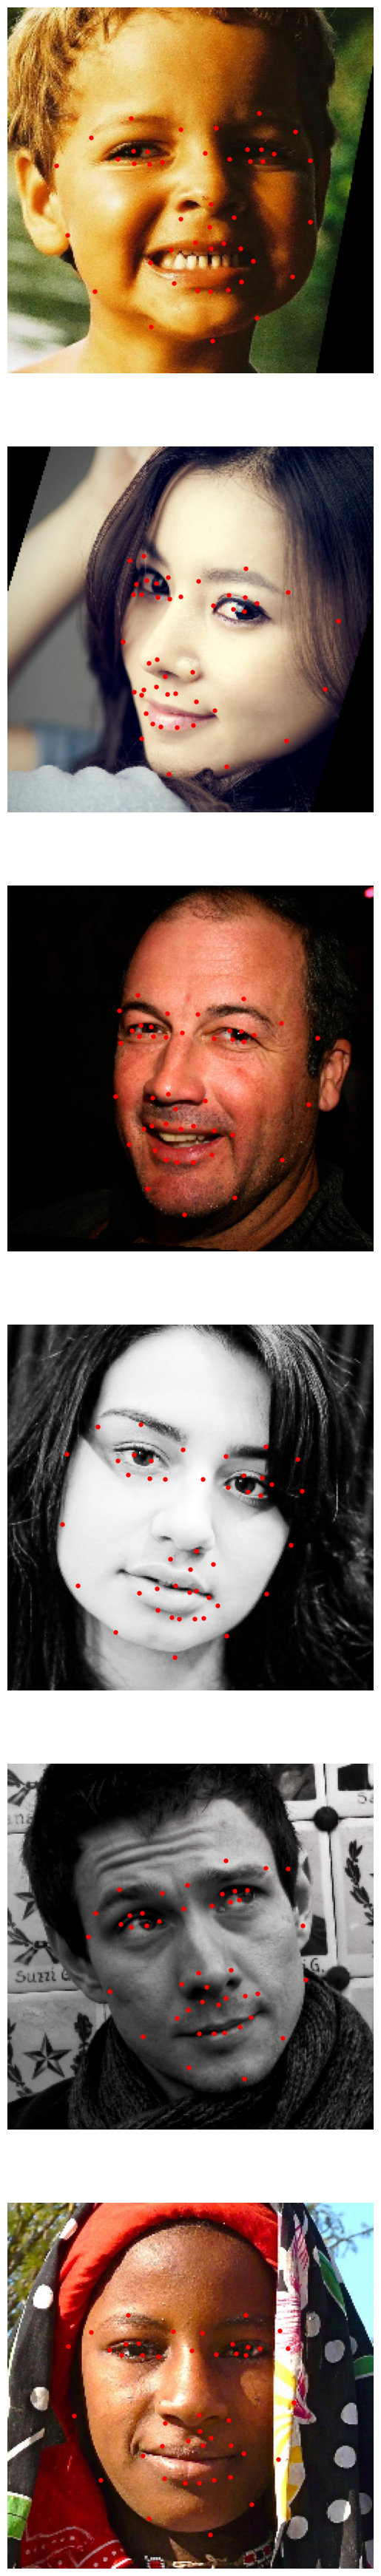

In [60]:
def plot_landmarks(images, landmarks, num_examples=6):
    fig, axs = plt.subplots(nrows=num_examples, ncols=1, figsize=(12, 45))
    for i in range(num_examples):
        ax = axs[i]
        image = images[i]
        landmark = landmarks[i]

        ax.imshow(image)
        ax.scatter(landmark[:, 0], landmark[:, 1], c='r', marker='.', s=50)
        ax.axis('off')
    
    plt.show()

test_images = np.load('test_images.npz')['images']
# Load the predicted landmark points from the file saved by evaluate_model
predictions = np.load('test_predictions.npz')['predictions']
plot_landmarks(test_images, predictions)

# **Lip/Eye Color Modification System**

In [49]:
def modify_lip_color(image, landmarks, color=(255, 0, 0)):
    
    lip_points = landmarks[32:44]  

    # Convert lip points to numpy array
    lip_points = np.array(lip_points, dtype=np.int32)

    # Create a mask for the lip region
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [lip_points], 255)

    # Apply the new color to the lip region
    modified_image = np.copy(image)
    modified_image[mask == 255] = color

    return modified_image

def modify_eye_color(image, landmarks, color=(0, 255, 0)):
    eye_points = landmarks[20:32] 

    # Convert eye points to numpy array
    eye_points = np.array(eye_points, dtype=np.int32)

    # Create a mask for the eye region
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [eye_points], 255)

    # Apply the new color to the eye region
    modified_image = np.copy(image)
    modified_image[mask == 255] = color

    return modified_image

## **Example of lip/eye color modification**

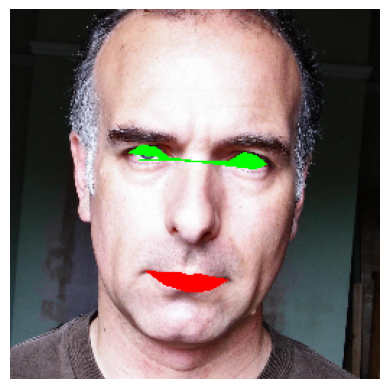

In [50]:
# Load the image and corresponding landmarks
image_array = train_images[9]  # Assuming the image is stored as an array
landmarks = train_points[9]    # Assuming landmarks are stored as (x, y) coordinates

# Apply lip color modification
modified_image = modify_lip_color(image_array, landmarks)

# Apply eye color modification
modified_image = modify_eye_color(modified_image, landmarks)

# Display the modified image
plt.imshow(modified_image)
plt.axis('off')
plt.show()


## **Exporting Results**


In [54]:
# Save face landmark positions to a CSV file
def save_landmark_positions(predictions, output_file='landmark_positions.csv'):
    with open(output_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        for landmarks in predictions:
            writer.writerow(landmarks.flatten())

save_landmark_positions(predictions)

In [56]:
model.save("trained_model.h5")